In [35]:
import numpy as np
import pandas as pd
import pickle
np.set_printoptions(precision=2)
pd.set_option('display.max_columns', 50)


from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn')


In [38]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [39]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


Приведу АВ признаки к числовым.

In [40]:
def AB_to_int(ser):
    if ser == 'A':
        return 1
    elif ser == 'B':
        return 0
    else:
        return ser

In [41]:
df['Ecology_2'] = df['Ecology_2'].apply(AB_to_int)
set(df['Ecology_2'])

{0, 1}

In [42]:
df['Ecology_3'] = df['Ecology_3'].apply(AB_to_int)
set(df['Ecology_2'])

{0, 1}

In [43]:
df['Shops_2'] = df['Shops_2'].apply(AB_to_int)
set(df['Shops_2'])

{0, 1}

In [45]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,0,0,33,7976,5,NaN,0,11,0,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,0,0,46,10309,1,240.0,1,16,0,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,0,0,34,7759,0,229.0,1,3,0,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,0,0,23,5735,3,1084.0,0,5,0,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,0,0,35,5776,1,2078.0,2,4,0,150226.531644


In [46]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2          int64
Ecology_3          int64
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2            int64
Price            float64
dtype: object

In [47]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,0.009700,0.027500,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,0.082500,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,0.275139,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,0.000000,0.000000,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,0.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,0.000000,0.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,0.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,0.000000,0.000000,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,0.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


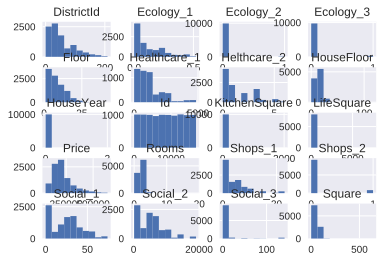

In [12]:
df.hist();

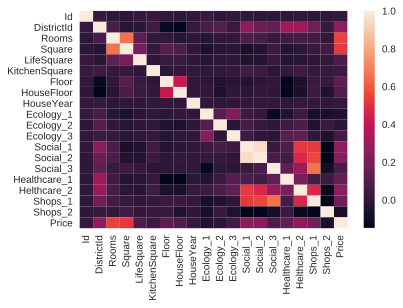

In [14]:
sns.heatmap(df.corr());

In [15]:
df[['Floor', 'Rooms']].head()

,Floor,Rooms
0,7,2.0
1,7,3.0
2,8,2.0
3,8,2.0
4,11,1.0


Пример выборки

In [17]:
df.loc[df['Ecology_2']== 0, ['Floor', 'Rooms']].head()

,Floor,Rooms
0,7,2.0
1,7,3.0
2,8,2.0
3,8,2.0
4,11,1.0


Сравнение средних, выборка по признаку.

In [18]:

df[df['Ecology_2']== 0]['Price'].mean(), \
df[df['Ecology_2']== 1]['Price'].mean()


(214344.5442227426, 193139.71700581786)

In [19]:
set(df['Ecology_2'])

{0, 1}

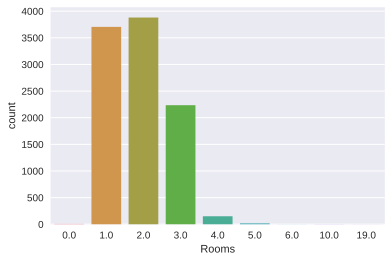

In [20]:
sns.countplot(df['Rooms']);

Объединение по 2 условиям

In [21]:
df[(df['Rooms'] == 1) & (df['Rooms'] == 1) &(df['Ecology_3'] == 0)].describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,3618.000000,3618.000000,3618.0,3618.000000,2740.000000,3618.000000,3618.000000,3618.000000,3.618000e+03,3618.000000,3618.000000,3618.0,3618.000000,3618.000000,3618.000000,1717.000000,3618.000000,3618.000000,3618.000000,3618.000000
mean,8413.968491,46.912659,1.0,41.372660,25.254694,6.502764,8.685738,13.073798,7.528600e+03,0.118453,0.008845,0.0,23.358209,5109.904367,7.316197,1054.626092,1.173300,3.974848,0.089552,159194.691281
std,4852.580553,40.833872,0.0,11.501884,14.383524,46.937009,5.235977,6.810872,3.333348e+05,0.119477,0.093642,0.0,18.057597,4112.541422,23.643048,908.790176,1.454151,4.801757,0.285579,51488.373126
min,0.000000,0.000000,1.0,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,0.0,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,0.000000,60502.583500
25%,4054.000000,20.000000,1.0,36.740866,19.685677,1.000000,4.000000,9.000000,1.977000e+03,0.017647,0.000000,0.0,5.000000,1564.000000,0.000000,370.000000,0.000000,0.000000,0.000000,127999.779211
50%,8497.000000,30.000000,1.0,40.435642,21.712081,6.000000,8.000000,14.000000,1.977000e+03,0.072158,0.000000,0.0,23.000000,5212.000000,1.000000,800.000000,1.000000,2.000000,0.000000,154041.682232
75%,12638.500000,63.000000,1.0,43.622065,24.351001,8.000000,12.000000,17.000000,2.004000e+03,0.210473,0.000000,0.0,35.000000,7065.000000,4.000000,1406.000000,2.000000,5.000000,0.000000,181831.657032
max,16798.000000,209.000000,1.0,409.425181,410.639749,2014.000000,37.000000,99.000000,2.005201e+07,0.521867,1.000000,0.0,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,594565.299770


Группировка и обработка в цикле 
Явно странные значения цены.

In [63]:
for look, sub_df in df.groupby('Rooms'):
    print(look, sub_df['Price'].median())
    

0.0 214937.0687870998
1.0 154979.4979927862
2.0 200320.75463588338
3.0 268723.1576769648
4.0 377524.2319895921
5.0 455355.63821232785
6.0 229661.9644160636
10.0 244797.29732772417
19.0 78364.61670430844


In [22]:
# По 2 признакам
for look, sub_df in df.groupby(['Rooms', 'Ecology_2']):
    print(look, sub_df['Price'].median())

(0.0, 0) 214937.0687870998
(1.0, 0) 155077.66708170346
(1.0, 1) 145365.78802436066
(2.0, 0) 200452.78213119705
(2.0, 1) 189676.95724077884
(3.0, 0) 268994.5810994068
(3.0, 1) 230916.95955366635
(4.0, 0) 378064.864846401
(4.0, 1) 318371.83422089065
(5.0, 0) 455355.63821232785
(6.0, 0) 229661.9644160636
(10.0, 0) 244797.29732772417
(19.0, 0) 78364.61670430844


аггрегирование по группам

In [23]:
df.groupby('Ecology_2')['Price'].agg(np.median)

Ecology_2
0    192371.633485
1    182516.558181
Name: Price, dtype: float64

Сводная таблица, данные по признакам Social

In [28]:
pd.crosstab(df['Ecology_2'], df['Ecology_3'])

Ecology_3,0,1
Ecology_2,,
0,9628,275
1,97,0


посчитаю среднюю цену

In [29]:
df.groupby(['Ecology_2', 'Ecology_3', 'Shops_2'])['Price'].agg(np.mean)

Ecology_2  Ecology_3  Shops_2
0          0          0          215416.899449
                      1          192908.557092
           1          0          243179.560704
1          0          0          198833.005156
                      1          159386.651546
Name: Price, dtype: float64

Добавлю признак "дорогой" 


In [30]:
df['Is_expensive'] = (df['Price'] > df['Price'].quantile(0.75)).astype('int32')

Применю функцию к столбцам

In [31]:
df[['Price', 'Square']].apply(np.median)

Price     192269.644879
Square        52.513310
dtype: float64

In [50]:
df['Shops_1'].value_counts()

0     2316
1     1325
5     1324
2      964
4      841
3      711
6      487
11     401
9      316
7      294
8      253
23     245
10     215
15     176
16      83
19      49
Name: Shops_1, dtype: int64

In [52]:
df.sort_values(by=['Price'], ascending=False).tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6856,2648,23,1.0,34.670830,NaN,0.0,4,0.0,1977,0.005767,0,0,1,388,0,NaN,0,0,0,60828.260686
9961,1579,23,1.0,27.331108,NaN,1.0,10,12.0,1977,0.034656,0,0,0,168,0,NaN,0,0,0,60825.032060
7850,8800,23,1.0,29.706031,NaN,0.0,5,12.0,1977,0.034656,0,0,0,168,0,NaN,0,0,0,60502.583500
3605,7243,9,2.0,58.089253,52.460857,8.0,5,22.0,1981,0.136244,0,0,11,2370,0,NaN,0,1,0,59877.592523
9732,13237,144,2.0,51.726692,30.547287,8.0,2,14.0,1988,0.306977,0,0,27,5148,14,1575.0,5,7,0,59174.778028


СОздание признака из словаря с использованием map

In [34]:
dic = {1: 'good', 0:'bad'}
ecology_2_txt = df['Ecology_2'].map(dic)
ecology_2_txt.head()

0    bad
1    bad
2    bad
3    bad
4    bad
Name: Ecology_2, dtype: object

### Вставка столбца в середину df

In [55]:
df.insert(loc=10, column='Ecology_2_txt', value=ecology_2_txt)


ValueError: cannot insert Ecology_2_txt, already exists

In [56]:
df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_txt,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,bad,0,0,46,7960,6,350.0,3,11,0,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,bad,0,0,30,5562,0,NaN,0,5,1,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,bad,0,0,2,629,1,NaN,0,0,1,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,bad,0,1,30,5048,9,325.0,2,5,0,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,bad,0,0,27,4798,0,30.0,2,8,0,218714.077615
